# Logistic Regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics
import warnings
import math
warnings.filterwarnings("ignore")

### Sigmoids

The sigmoid function is given by 

$\sigma(z) = \frac{1}{1 + e^{-z}}$

Implement this below.

In [ ]:
def sigmoid(z):
    x = []
    for m in z:
        x= x + [1 / (1 + math.exp(-m))]
        
    z=x
    return z

As noted in lecture, the output should lie between 0 and 1, centred at 0.5.

In [ ]:
x = np.arange(-10,10,0.1)
y = sigmoid(x)
plt.grid()
plt.plot(x,y)
plt.show()

### Loss Function

To fit a Logistic Regression model for binary classification, the loss function (negative of the likelihood) is given by

$l(\beta) = - \frac{1}{n} \sum_{i=1}^{n} \{ y_i \log p(x_i;\beta) + (1-y_i) \log (1 - p(x_i;\beta))\}$

where $p(x_i;\beta) = p(Y = 1 | X = x_i) = \frac{1}{1 + e^{-(\beta^T x_i)}} = \sigma(\beta^T x_i)$

Note that $\beta_0$ has been folded into the vector $\beta$, as in Linear Regression, by adding a column of ones to the data matrix $X$.

Implement the given loss function below. You can use the vector form of the loss function, given by

$l(\beta) = - \frac{1}{n} \{ y_i \log (\sigma(X^T\beta)) + (1-y_i) \log (\sigma(X^T\beta))\}$

In [ ]:
def loss_function(beta, X, y):
    X_transpose = np.transpose(X)
    loss=0
    for i in range(len(y)):
        inputX = X_transpose[i].dot(beta)
        hypotehsisValue = sigmoid(inputX)[0]
        loss = loss + ((-1/len(X))*((y[i]*math.log(hypotehsisValue))+((1-y[i])*math.log(hypotehsisValue))))
    return loss

In [ ]:
# Adding a column of ones to get intercept coefficient beta_0 
def add_intercept(X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

### A simple optimizer - Gradient Descent

To obtain the Logistic Regression classifier, we need to find the parameters that will minimize the loss function defined above. As noted in the lecture, usually a Newton-Raphson or similar optimizer is used in practice (including in the sklearn package). 

For this example, we will implement a simple gradient descent optimizer as follows.

1. Initialize $\beta$ to be a vector of zeros, and set learning rate $lr$
2. For each iteration of gradient descent
   
   - Compute the gradient of the loss function
   
      $grad(l) = \frac{1}{n}(X^T(\sigma(\beta^T X) - y))$
   
   - Update the parameters
   
      $\beta \leftarrow \beta - (lr*grad)$
      
      
3. Repeat step 2 till the number of iterations runs out, or the change in loss is less than some tolerance value (say 0.0001)

In [ ]:
def fit(X,y,lr=0.01, num_iter=1000, tol=1E-4):
    beta = np.zeros((len(X[0]),1))
    X = np.transpose(X)
    while num_iter>0 :
        beta_transpose = np.transpose(beta)
        inputX = beta_transpose.dot(X)
        inputX = np.transpose(inputX)
        grad = 1/(len(X))*(X.dot(sigmoid(inputX)-y)) 
        grad = grad.reshape(2,1)
        prev = loss_function(beta,X,y)
        beta = beta - lr*grad
        current = loss_function(beta,X,y)
        if abs(prev-current) < tol:
            return beta
        num_iter = num_iter - 1        
    return beta

The above function will find the coefficients $\beta$ for the model. We can now make predictions for a test input $x$. This is done by finding the conditional probability $p(Y = 1 | X = x)$, and then thresholding at 0.5.

$p(Y = 1 | X = x) = \frac{1}{1 + e^{-(\beta^T x)}} = \sigma(\beta^T x)$

$g(x) = 
\begin{cases}
1 \text{ if } p(Y = 1 | X = x) \ge 0.5 \\
0 \text{ if } p(Y = 1 | X = x) < 0.5
\end{cases}$

Implement these below.

In [ ]:
# Return the probability P(Y=1|X=x)
def predict_prob(X,beta):
    beta_transpose = np.transpose(beta)
    X_transpose = np.transpose(X)
    inputX =(beta_transpose.dot(X_transpose)) 
    inputX = inputX.reshape(len(inputX[0]))
    p = sigmoid(inputX)
    return p

In [ ]:
# Return the predictions for the model (0 or 1)
def predict(X,beta):
    g = 1 if predict_prob(X,beta) >= 0.5 else 0
    return g

# Trying out the classifier

Let's use the following toy data.

In [ ]:
def generate_2d_data(class1Mean, class1Cov, class2Mean, class2Cov, plot=False):
    
    np.random.seed(1)
    class1x = np.random.multivariate_normal(class1Mean, class1Cov, 100)
    class1y = np.zeros(100)
    class2x = np.random.multivariate_normal(class2Mean, class2Cov, 100)
    class2y = np.ones(100)
    x = np.concatenate((class1x, class2x), axis=0)
    y = np.concatenate((class1y, class2y))

    if(plot==True):
        # Plotting the 2-class data
        plt.title('Plotting 2-dimensional 2-class data')
        plt.scatter(class1x[:,0], class1x[:,1], color = 'b', label = 'Class 1')
        plt.scatter(class2x[:,0], class2x[:,1], color = 'r', label = 'Class 2')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.show()
    
    return x,y

class1Mean = [0, 0]
class1Cov = [[1, 0], [0,1]]

class2Mean = [2, 2]
class2Cov = [[1, 0], [0,1]]

X,y = generate_2d_data(class1Mean, class1Cov, class2Mean, class2Cov, plot=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
def plot(X, y, theta=None, model_type=None, clf=None, show_vectors=False):

    cmap = plt.cm.coolwarm
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02    
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    temp = np.c_[xx.ravel(), yy.ravel()]

    if(model_type=='sklearn'):
        P = clf.predict(temp).reshape(yy.shape)
    else:
        P = predict(temp,theta).reshape(yy.shape)
    plt.pcolormesh(xx, yy, P, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor='k')    
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [ ]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


Train the model below, using a learning rate of 0.01. Print the loss every 50 iterations so that you can monitor the progress of the algorithm.

In [ ]:
beta = fit(X=X_train,y=y_train)
print(beta)
plot(X_train,y_train,beta)

In [ ]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


For comparison, here is the result of scikit-learn's Logistic Regression implementation.

[[1.20543367 1.45351909]]
Accuracy = 0.95


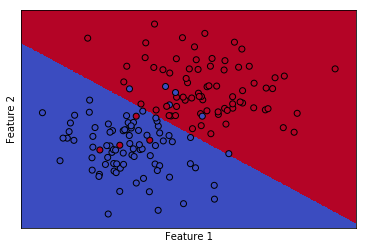

In [447]:
X,y = generate_2d_data(class1Mean, class1Cov, class2Mean, class2Cov)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(clf.coef_)
print('Accuracy = ' + str(metrics.accuracy_score(y_test,y_pred)))
plot(X_train,y_train,model_type='sklearn',clf=clf)

### Another example - odd and even digits

Here is a dataset of digits, where the label is set to 0 if the digit is even and 1 if the digit is odd.

In [ ]:
data = datasets.load_digits()
X = data.data
y = (data.target % 2 == 0) * 1
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=123)

Use the Logistic Regression classifier as above, with a learning rate of 0.01, for this task.

In [ ]:
#
# YOUR CODE HERE
#
print('Accuracy = ' + str(metrics.accuracy_score(y_test,y_pred)))

You can see a few of the model's predictions plotted below.

In [ ]:
images_and_predictions = list(zip(X_test, y_pred))
for index, (image, prediction) in enumerate(images_and_predictions[:20]):
    plt.subplot(4, 10, index + 11)
    plt.axis('off')
    plt.imshow(image.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    if(prediction==1):
        plt.title('even')
    elif(prediction==0):
        plt.title('odd')

In [ ]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


### On the fence

One of the advantages of the Logistic Regression classifier is that we directly obtain the probabilities associated with every prediction.

Let us look at the predictions that the classifier has made with lower confidence. Obtain all the predictions for which the probability is between 0.45 and 0.55. 

In [ ]:
#
# YOUR CODE HERE
#
print(p_uncertain)

Now plot 10 of these digits and examine the predictions. Think about why these digits were predicted with low confidence.

In [ ]:
#
# YOUR CODE HERE
#


In [ ]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


# Decision Trees

In [ ]:
import graphviz
from sklearn import tree
import pandas as pd

Let us work with the Pima Indians Diabetes dataset. This dataset has 8 features.

In [ ]:
feature_names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'output']
data = pd.read_csv('pima-indians-diabetes.data', sep=",", header=None, names=feature_names)
feature_names = feature_names[:-1]
X = data.values[:,:-1]
y = data.values[:,-1].astype(int)
num_attributes = X.shape[1]
data.head()

Classify the given dataset using a Decison Tree.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5)
#
# YOUR CODE HERE
#
acc = metrics.accuracy_score(y_pred,y_test)
print(acc)

In [ ]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


You can use GraphViz to visualize the learned tree

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=feature_names) 
graph = graphviz.Source(dot_data)
graph

Now, use only two features from the dataset for the classification. Find the two features that result in the best classification accuracy.

In [ ]:
#
# YOUR CODE HERE
#


## Finding split points for trees - the Gini Index

We will find the best split point for the following toy dataset. Let us implement the Gini Index measure for this.

In [185]:
dataset = np.array([[11.7,183.2,0],
           [12.8,187.6,0],
           [15.3,177.4,0],
           [13.9,198.6,0],
           [17.2,175.3,0],
           [16.8,151.1,1],
           [17.5,171.4,1],
           [23.6,162.8,1],
           [16.9,179.5,1],
           [19.1,173.8,1]])
X = dataset[:,:-1]
y = dataset[:,-1]

The following helper function is provided. It will separate a dataset into two lists of rows, given a feature and a split value for that feature.

In [186]:
def split(feature_id, value, dataset):
    left = []
    right = []
    for row in dataset:
        if row[feature_id] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

Now, calculate the Gini Index for a given split

$gini(D) = 1 - \sum_{j=1}^K p_j^2$ where $K$ is the number of classes

If the dataset is split at value A into two datasets $D_1$ and $D_2$, the Gini index for the split is given by

$gini_A(D) = \frac{|D_1|}{|D|}gini(D_1) + \frac{|D_2|}{|D|}gini(D_2)$

In [195]:
def gini_index(groups, classes=[0,1]):
    n_instances = 10
    if isinstance(groups, tuple) :
        gini = len(groups[0])/n_instances*gini_index(groups[0],classes)+len(groups[1])/n_instances*gini_index(groups[1],classes)
    else :
        group1 = sum(groups[:])[2]
        group2 = len(groups) - group1
        gini = 1-((group1**2+group2**2)/len(groups)**2)
    return gini

groups = split(1,174.55,dataset)
print('Gini index for X2 < 174.55 = ' + str(gini_index(groups)))
groups = split(1,176.35,dataset)
print('Gini index for X2 < 176.35 = ' + str(gini_index(groups)))
groups = split(1,178.45,dataset)
print('Gini index for X2 < 178.45 = ' + str(gini_index(groups)))
groups = split(1,185.4,dataset)
print('Gini index for X2 < 185.4 = ' + str(gini_index(groups)))

Gini index for X2 < 174.55 = 0.16666666666666666
Gini index for X2 < 176.35 = 0.31999999999999995
Gini index for X2 < 178.45 = 0.4166666666666667
Gini index for X2 < 185.4 = 0.375


In [196]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


Now, we enumerate every possible split point and find its Gini index. The split that gives the lowest Gini index will be the best split. The following pseudocode should help with the implementation.

- For every feature $A$ in the dataset
    - For every row in the dataset
        - With feature $A$'s value as a split point, obtain the split and find its Gini index. 
        - If the Gini index is lower than the best score, save the split point
- Return the best split point

In [197]:
def get_split(dataset):
    best_score = 1
    features = len(dataset[0])-1
    numOfInstances = len(dataset)-1
    dataset = dataset.tolist()
    for i in range(features):
        sortedList = sortByFeature(dataset,i)
        for j in range(numOfInstances):
            splitPoint=(sortedList[j][i]+sortedList[j+1][i])/2
            if sortedList[j][i] != splitPoint:
                groups = split(i,splitPoint,np.asarray(dataset))
                giniValue = gini_index(groups)
                if best_score >= giniValue:
                    best_score = giniValue
                    best_feature = i
                    best_value = splitPoint
                    best_groups = groups
    return best_feature, best_value, best_groups


def sortByFeature(dataset,feature):
    for  i in range(len(dataset)):
        for j in range(len(dataset)):
            if dataset[i][feature] < dataset[j][feature]:
                temp = dataset[i]
                dataset[i] = dataset[j]
                dataset[j] = temp
    return dataset


In [198]:
best_feature, best_value, _ = get_split(dataset)
print('Best split: X' + str(best_feature+1) + ' <  ' + str(best_value))

Best split: X2 <  174.55


In [346]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [347]:
sigmoid([0]*154)

[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5]